In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
import model
import json
from argparse import Namespace
import utility
import torch
import torch.nn.functional as F

from enum import Enum

%matplotlib inline

In [2]:
def np2Tensor(*args, rgb_range=255, single_test=False):
    def _np2Tensor(img):
        np_transpose = np.ascontiguousarray(img.transpose((2, 0, 1)))
        if single_test:
            np_transpose = np.expand_dims(np_transpose, 0)
        tensor = torch.from_numpy(np_transpose).float()
        tensor.mul_(rgb_range / 255)

        return tensor

    return [_np2Tensor(a) for a in args]


class TensorRotate(Enum):
    """Rotate enumerates class"""
    NONE = lambda x: x
    ROTATE_90_CLOCKWISE = lambda x: x.transpose(1, 2).flip(2)
    ROTATE_180 = lambda x: x.flip(1, 2)
    ROTATE_90_COUNTERCLOCKWISE = lambda x: x.transpose(1, 2).flip(1)
    HORIZONTAL_FLIP = lambda x: x.flip(2)
    VERTICAL_FLIP = lambda x: x.flip(1)
    RGB_SHIFT = lambda x: x.flip(0)


def rotate_tensor(img: torch.Tensor, rot_value: TensorRotate) -> torch.Tensor:
    """Rotate image tensor
    Args:
        img: tensor in CHW format
        rot_value: element of TensorRotate class, possible values
            TensorRotate.NONE,
            TensorRotate.ROTATE_90_CLOCKWISE,
            TensorRotate.ROTATE_180,
            TensorRotate.ROTATE_90_COUNTERCLOCKWISE,
    Returns:
        Rotated image in same of input format
    """
    return rot_value(img)


def tta_inference(_t: torch.Tensor, _model: torch.nn.Module) -> torch.Tensor:
    transforms = [
        TensorRotate.NONE,
        TensorRotate.ROTATE_90_CLOCKWISE,
        TensorRotate.ROTATE_180,
        TensorRotate.ROTATE_90_COUNTERCLOCKWISE,
        TensorRotate.HORIZONTAL_FLIP,
        TensorRotate.VERTICAL_FLIP,
        # TensorRotate.RGB_SHIFT
    ]

    inv_transforms = [
        TensorRotate.NONE,
        TensorRotate.ROTATE_90_COUNTERCLOCKWISE,
        TensorRotate.ROTATE_180,
        TensorRotate.ROTATE_90_CLOCKWISE,
        TensorRotate.HORIZONTAL_FLIP,
        TensorRotate.VERTICAL_FLIP,
        # TensorRotate.RGB_SHIFT
    ]

    tta_batch = torch.stack(
        [rotate_tensor(_t, tr) for tr in transforms]
    )

    out = _model(tta_batch).detach()

    avg_out = torch.stack(
        [
            rotate_tensor(out[tri], tr)
            for tri, tr in enumerate(inv_transforms)
        ]
    )

    return avg_out.mean(dim=0)


WINDOW_SIZE = 256
INPUT_SIZE = None


def inference_tiling_intersected(
        img: torch.Tensor, single_inference: torch.nn.Module, tile_size=WINDOW_SIZE, input_size=INPUT_SIZE
) -> torch.Tensor:
    """
    Process the image with splitting on tiles.
    `singel_inferece` will be applied to each tile. Its expected the input
    image is torch.Tensor [C, H, W] shape of float type.
    """
    res_enchance_mask = torch.zeros(3, img.size(1), img.size(2), dtype=torch.float32, device=img.device)
    res_est_o_mask = torch.zeros(img.size(1), img.size(2), dtype=torch.float32, device=img.device)
    counter_mask = torch.zeros(img.size(1), img.size(2), dtype=torch.long, device=img.device)

    stride = tile_size // 4

    x0_vec = []
    y0_vec = []

    target_x = 0
    while target_x + tile_size < img.size(2):
        x0_vec.append(target_x)
        target_x += stride
    x0_vec.append(img.size(2) - tile_size - 1)

    target_y = 0
    while target_y + tile_size < img.size(1):
        y0_vec.append(target_y)
        target_y += stride
    y0_vec.append(img.size(1) - tile_size - 1)

    for y0 in y0_vec:
        for x0 in x0_vec:
            img_crop = img[:, y0:y0 + tile_size, x0:x0 + tile_size]
            # res = tta_inference(img_crop, single_inference)
            res_e, res_o = single_inference(img_crop.unsqueeze(0), 1)
            
            res_enchance_mask[:, y0:y0 + tile_size, x0:x0 + tile_size] += res_e[0]
            res_est_o_mask[y0:y0 + tile_size, x0:x0 + tile_size] += res_o[0][0]
            counter_mask[y0:y0 + tile_size, x0:x0 + tile_size] += 1

    return res_enchance_mask / counter_mask, res_est_o_mask / counter_mask

In [36]:
with open('args.json', 'r') as jf:
    args_dict = json.load(jf)
    args_dict['cpu'] = False
    args_dict['reset'] = False
    args = Namespace(**args_dict)

In [37]:
checkpoint = utility.checkpoint(args)
net = model.Model(args, checkpoint)
net.load(
    '../experiment/eye_1_split8_train_2/model/', 
    pre_train='../experiment/eye_1_split8_train_2/model/model_latest.pt',
    # pre_train='../pretrained/eye_k8.pt',
    cpu=False, resume=0)

Making model...
Load the model from ../experiment/eye_1_split8_train_2/model/model_latest.pt


In [38]:
image_path = '/media/alexey/HDDDataDIsk/datasets/RetinalVesselSegmentation/CompetitionDataset/test/911.png'
image = cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

img_tensor = np2Tensor(image)[0] 
print(img_tensor.shape, img_tensor.max())

torch.Size([3, 1232, 1624]) tensor(255.)


In [53]:
imgt = torch.zeros(1, 3, 2000, 2000)
imgt[0, :, :img_tensor.size(1), :img_tensor.size(2)] = img_tensor
imgt = imgt.to('cuda')

with torch.no_grad():
    # enchance, est_o = inference_tiling_intersected(img_tensor, net)
    enchance, est_o = net(imgt, 1)
    enchance = enchance.cpu()[0, :, :img_tensor.size(1), :img_tensor.size(2)]
    est_o = est_o.cpu()[0, 0, :img_tensor.size(1), :img_tensor.size(2)]
    
print(enchance.min(), enchance.max())
print(est_o.min(), est_o.max())

tensor(4.6948e-07) tensor(1.0000)
tensor(3.3344e-11) tensor(0.9971)


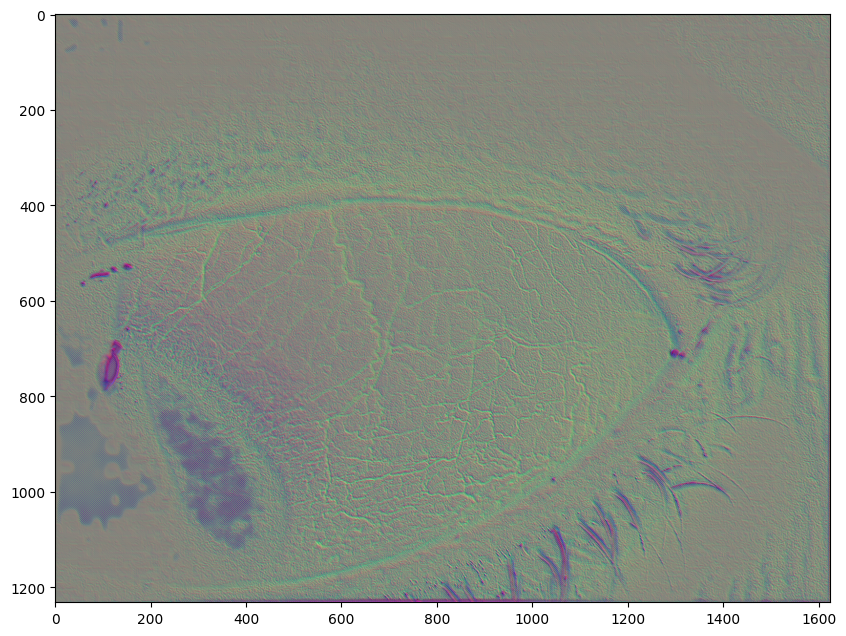

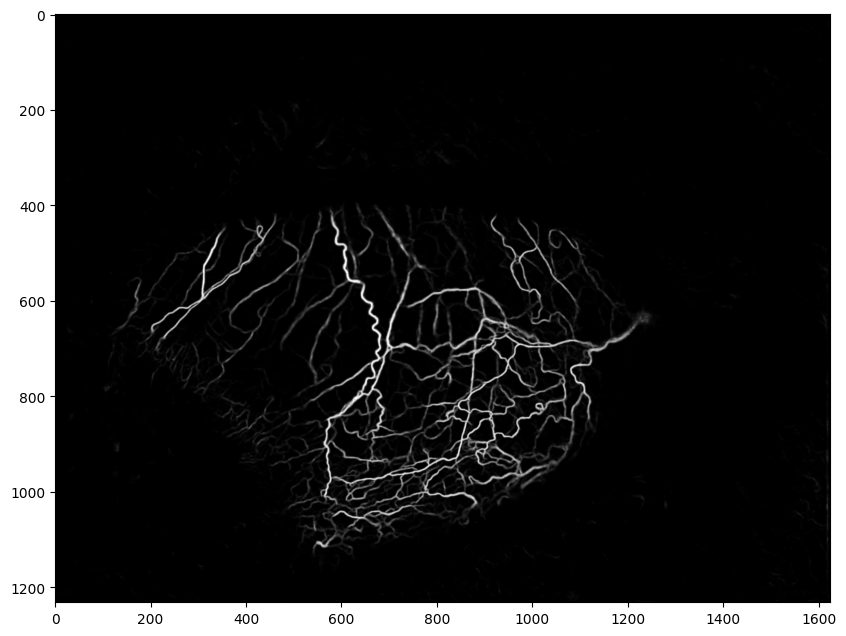

In [54]:
eimg = (enchance * 255.).permute(1, 2, 0).numpy().astype(np.uint8)
eomask = ((est_o > (100 / 255)) * 255).numpy().astype(np.uint8)

eomask = (est_o * 255).numpy().astype(np.uint8)

# eomask = cv2.morphologyEx(
#         eomask, cv2.MORPH_CLOSE,
#     cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=2
# )
# _, eomask = cv2.threshold(eomask, 127, 255, cv2.THRESH_BINARY)


plt.figure(figsize=(10, 8))
plt.imshow(eimg)
plt.figure(figsize=(10, 8))
plt.imshow(eomask, 'gray')
plt.show()

In [ ]:
test_folder = '/media/alexey/HDDDataDIsk/datasets/RetinalVesselSegmentation/CompetitionDataset/test/'
submit_folder = '/media/alexey/HDDDataDIsk/datasets/RetinalVesselSegmentation/CompetitionDataset/submit/'

# test_folder = '/media/alexey/HDDDataDIsk/datasets/RetinalVesselSegmentation/CompetitionDataset/segmentation_representation/val/images/'
# submit_folder = '/media/alexey/HDDDataDIsk/datasets/RetinalVesselSegmentation/CompetitionDataset/segmentation_representation/val/sgl_masks/'

os.makedirs(submit_folder, exist_ok=True)

for imgname in tqdm(os.listdir(test_folder)):
    image_path = os.path.join(test_folder, imgname)
    out_path = os.path.join(submit_folder, imgname)
    np_path = os.path.join(submit_folder, os.path.splitext(imgname)[0] + '.npy')
    
    image = cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    img_tensor = np2Tensor(image)[0]
    
    imgt = torch.zeros(1, 3, 2000, 2000)
    imgt[0, :, :img_tensor.size(1), :img_tensor.size(2)] = img_tensor
    imgt = imgt.to('cuda')

    with torch.no_grad():
        enchance, est_o = net(imgt, 1)
        enchance = enchance.cpu()[0, :, :img_tensor.size(1), :img_tensor.size(2)]
        est_o = est_o.cpu()[0, 0, :img_tensor.size(1), :img_tensor.size(2)]
        
    eomask = (est_o * 255.).numpy().astype(np.uint8)
    eomask = ((eomask > 100) * 255).astype(np.uint8)
    
    init_mask = eomask.copy()
    contours, hierarchy = cv2.findContours(init_mask, cv2.RETR_TREE,
                                               cv2.CHAIN_APPROX_SIMPLE)

    cnt_areas = np.array([cv2.contourArea(cnt) for cnt in contours])

    # th = cnt_areas.mean() / 4
    th = 50

    selected_contours = [
        cnt
        for cnt in contours
        if cv2.contourArea(cnt) > th
    ]

    new_mask = np.zeros_like(init_mask)

    new_mask = cv2.drawContours(new_mask, selected_contours, -1, 255, -1)
    eomask = np.bitwise_and(init_mask, new_mask)

    # np.save(np_path, est_o.numpy())
    assert cv2.imwrite(out_path, eomask)

 66%|███████████████████████████████████████████████████████████████████████                                     | 198/301 [01:33<00:49,  2.06it/s]